In [8]:
import pandas as pd
import numpy as np
import tqdm
from rapidfuzz import fuzz
from Bio import SeqIO
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [75]:
input_array = [
    {'ref': 'AAGAAAGTTGTCGGTGTCTTTGTG',
     'path': 'input/NB_23052024_VR/barcode01/FAX54985_pass_barcode01_1af735a5_a7a0fffd_0.fastq'},
    {'ref': 'TCGATTCCGTTTGTAGTCGTCTGT',
     'path': 'input/NB_23052024_VR/barcode02/FAX54985_pass_barcode02_1af735a5_a7a0fffd_0.fastq'},
    {'ref': 'AAGGTTACACAAACCCTGGACAAG',
     'path': 'input/FAX54985_pass_barcode05_61ab2510_eb99195c_0.fastq'},
    {'ref': 'GACTACTTTCTGCCTTTGCGAGAA',
     'path': 'input/FAX54985_pass_barcode06_61ab2510_eb99195c_0.fastq'},
    {'ref': 'GGCTTCTGGACTACCTATGC',
     'path': 'input/merged.fastq'},
    {'ref': 'ACCGGGATTCTCACTAAGCG',
     'path': 'input/barcode05_merged.fastq'},
    {'ref': 'CTCCTCTGACTGTAACCACG',
     'path': 'input/bigfile.fastq'},
    {'ref': 'AAGGATTCATTCCCACGGTAA',
     'path': 'input/PAQ39826_pass_barcode07_8074fd48_d90929d6_0.fastq'},
    {'ref': 'TCGATTCCGTTTGTAGTCGTCTGT',
     'path': 'input/NB_23052024_VR/barcode02/merged_barcode02.fastq'},
    {'ref': 'TCCGATTCTGCTTCTTTCTACCTG',
     'path': 'input/burdenko_96/barcode12/FAW03810_pass_barcode12_e0e94029_9b079ef7_0.fastq'},
    {'ref': 'AAGGTTACACAAACCCTGGACAAG',
     'path': 'input/burdenko_96/barcode05/FAW03810_pass_barcode05_e0e94029_9b079ef7_0.fastq'},
    {'ref': 'TAGGGAAACACGATAGAATCCGAA',
     'path': 'input/burdenko_96/barcode04/FAW03810_pass_barcode04_e0e94029_9b079ef7_0.fastq'}
]

In [49]:
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

In [50]:
def calculate_noise(arr, window_size=3):
    smoothed = moving_average(arr, window_size)
    extended_smoothed = np.concatenate((arr[:window_size - 1], smoothed))
    noise = arr - extended_smoothed
    return noise

In [51]:
def calculate_snr(arr, window_size=3):
    noise = calculate_noise(arr, window_size)
    noise_power = np.var(noise)
    signal_power = np.var(arr)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [57]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [52]:
def find_fuzzy_substring_matches(s, reference, treshold):
    length = len(reference)
    substrings = [s[i:i + length] for i in range(len(s) - length + 1)]
    arr = [(s.find(i),fuzz.ratio(i, reference)) for i in substrings if fuzz.ratio(i, reference) >= treshold*100]
    if len(arr) > 0:
        idx, values = zip(*arr)
        peak_indices, _ = find_peaks(values, distance=length)
        if len(peak_indices) > 0:
            return [idx[item] for item in peak_indices.tolist()]
        else:
            return None
    else:
        return None

In [53]:
def get_all_occurrences(reference, all_sequences, n_records, avg_length, threshold=0.9):
    occurrences = []
    for s in all_sequences:
        try:
            occurrences.extend(find_fuzzy_substring_matches(s, reference, threshold))
        except Exception as e:
            pass
    unique_values, counts = np.unique(sorted(occurrences), return_counts=True)
    data = [{'index': value, 'reads': count, 'proportion': count / n_records} for value, count in zip(unique_values, counts)]
    df = pd.DataFrame(data)
    all_indexes = pd.Series(range(0, avg_length))
    result = all_indexes.to_frame('index').merge(df, on='index', how='left').fillna(0)
    result['smoothed'] = result['reads'].rolling(window=5, min_periods=1, center=True).mean()
    return result.dropna()

0.5018945394939445
AAGAAAGTTGTCGGTGTCTTTGTG in input/NB_23052024_VR/barcode01/FAX54985_pass_barcode01_1af735a5_a7a0fffd_0.fastq: noise level = 0.5018945394939445
0.6958317119826678
TCGATTCCGTTTGTAGTCGTCTGT in input/NB_23052024_VR/barcode02/FAX54985_pass_barcode02_1af735a5_a7a0fffd_0.fastq: noise level = 0.6958317119826678
0.13661633028987752
AAGGTTACACAAACCCTGGACAAG in input/FAX54985_pass_barcode05_61ab2510_eb99195c_0.fastq: noise level = 0.13661633028987752
0.1309188024423133
GACTACTTTCTGCCTTTGCGAGAA in input/FAX54985_pass_barcode06_61ab2510_eb99195c_0.fastq: noise level = 0.1309188024423133
0.34923346148359996
GGCTTCTGGACTACCTATGC in input/merged.fastq: noise level = 0.34923346148359996
0.13879928390293864
ACCGGGATTCTCACTAAGCG in input/barcode05_merged.fastq: noise level = 0.13879928390293864
0.2541411066314961
CTCCTCTGACTGTAACCACG in input/bigfile.fastq: noise level = 0.2541411066314961
0.2752781680440772
AAGGATTCATTCCCACGGTAA in input/PAQ39826_pass_barcode07_8074fd48_d90929d6_0.fas

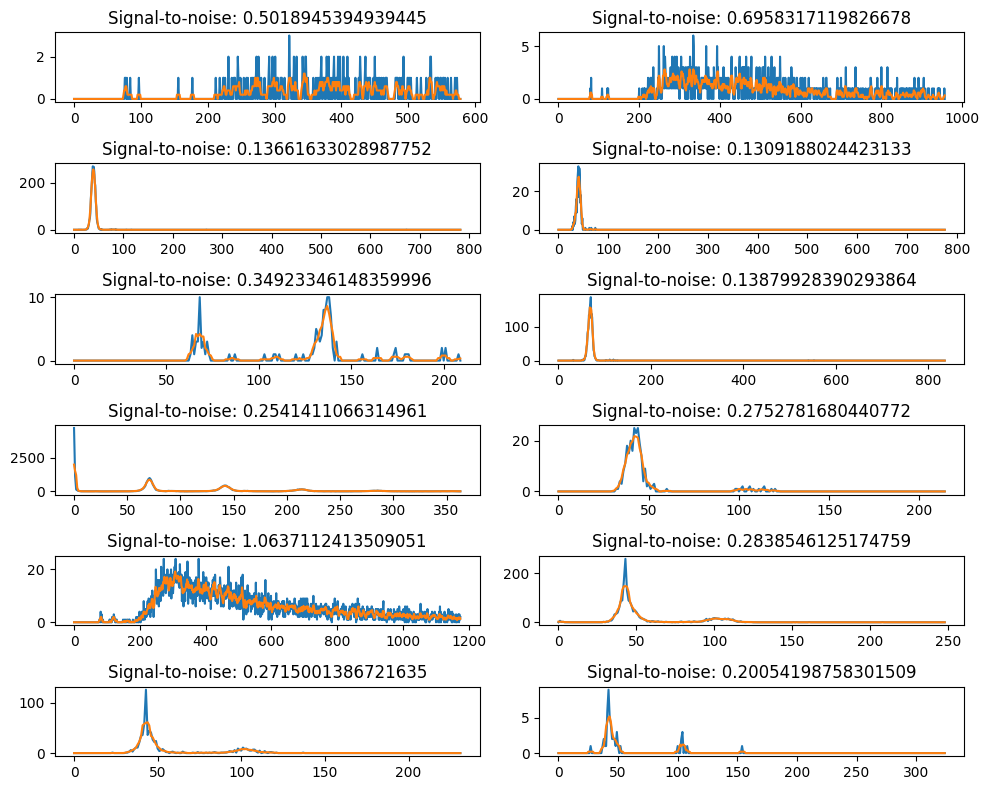

In [76]:
n = 6
m = 2
fig, axs = plt.subplots(n, m, figsize=(10, 8))
for idx,item in enumerate(input_array):
     row_index = idx // m
     col_index = idx % m

     ref = item['ref']
     path = item['path']
     records = list(SeqIO.parse(path, "fastq"))
     sequences = [str(rec.seq) for rec in records]
     avg_length = int(np.mean([len(s) for s in sequences]))
     df = get_all_occurrences(ref, sequences, len(records), avg_length, 0.9)
     # noise_level = calculate_snr(df['reads'], round(len(item['ref'])/2))
     snr = round(signaltonoise(df['reads']),2)
     # signaltonoise_v1 = signaltonoise_v1(df['reads'])
     print(snr)
     # print(noise_level)
     print(f'{ref} in {path}: noise level = {snr}')
     axs[row_index, col_index].plot(df['reads'])  
     axs[row_index, col_index].plot(df['smoothed']) 
     axs[row_index, col_index].set_title(f'Signal-to-noise: {snr}')

plt.tight_layout()
plt.show()